In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import numpy as np
from scipy.stats import shapiro, normaltest, probplot

from statsmodels.tsa.seasonal import seasonal_decompose

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
%run "variables.py"
%run "functions.ipynb"

In [3]:
# df = pd.read_csv(f'{DATA_DIR}/pred_maint_timeseries_with_failures.csv')
df = pd.read_csv(f'{DATA_DIR}/pred_maint_year_outliers_nulls.csv')
display(df.head())

,machineid,datetimestamp,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
0,1,2025-01-01 00:00:00,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
1,1,2025-01-01 00:10:00,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2,1,2025-01-01 00:20:00,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
3,1,2025-01-01 00:30:00,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
4,1,2025-01-01 00:40:00,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


In [4]:

df.drop(columns=['machineid'])
df = df.set_index('datetimestamp')
display(df.head())

,machineid,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
datetimestamp,,,,,,,,
2025-01-01 00:00:00,1,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
2025-01-01 00:10:00,1,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2025-01-01 00:20:00,1,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
2025-01-01 00:30:00,1,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
2025-01-01 00:40:00,1,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


# Features

Create features to perform Z-score model in time series dataframe df for anomaly detection

In [6]:
# Create features for Z-score anomaly detection
def create_zscore_features(df, window_sizes=[24, 72, 168]):
    """
    Create Z-score features for anomaly detection in time series data
    
    Parameters:
    df: DataFrame with time series data
    window_sizes: List of window sizes for rolling statistics (default: 24h, 72h, 168h)
    """
    df_features = df.copy()
    
    # Get numeric columns (exclude machineid if present)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if 'machineid' in numeric_cols:
        numeric_cols = numeric_cols.drop('machineid')
    
    for col in numeric_cols:
        # Global Z-score
        df_features[f'{col}_zscore_global'] = (df[col] - df[col].mean()) / df[col].std()
        
        # Rolling Z-scores for different window sizes
        for window in window_sizes:
            # Rolling mean and std
            rolling_mean = df[col].rolling(window=window, min_periods=1).mean()
            rolling_std = df[col].rolling(window=window, min_periods=1).std()
            
            # Z-score using rolling statistics
            df_features[f'{col}_zscore_rolling_{window}h'] = (df[col] - rolling_mean) / rolling_std
            
            # Additional features
            df_features[f'{col}_rolling_mean_{window}h'] = rolling_mean
            df_features[f'{col}_rolling_std_{window}h'] = rolling_std
            
            # Distance from rolling mean
            df_features[f'{col}_dist_from_mean_{window}h'] = abs(df[col] - rolling_mean)
    
    # Create composite anomaly scores
    zscore_cols = [col for col in df_features.columns if 'zscore' in col]
    
    # Maximum absolute Z-score across all features
    df_features['max_abs_zscore'] = df_features[zscore_cols].abs().max(axis=1)
    
    # Mean absolute Z-score
    df_features['mean_abs_zscore'] = df_features[zscore_cols].abs().mean(axis=1)
    
    # Anomaly flags (threshold = 3)
    df_features['anomaly_flag_3sigma'] = (df_features['max_abs_zscore'] > 3).astype(int)
    df_features['anomaly_flag_2sigma'] = (df_features['max_abs_zscore'] > 2).astype(int)
    
    return df_features

# Apply the function to create Z-score features
df_with_zscore_features = create_zscore_features(df)

print(f"Original shape: {df.shape}")
print(f"Shape with Z-score features: {df_with_zscore_features.shape}")
print(f"\nNew feature columns added: {df_with_zscore_features.shape[1] - df.shape[1]}")

# Display sample of new features
zscore_feature_cols = [col for col in df_with_zscore_features.columns if 'zscore' in col or 'anomaly' in col]
display(df_with_zscore_features[zscore_feature_cols].head(10))

Original shape: (262800, 8)
Shape with Z-score features: (262800, 103)

New feature columns added: 95


,enginegastemperature1_zscore_global,enginegastemperature1_zscore_rolling_24h,enginegastemperature1_zscore_rolling_72h,enginegastemperature1_zscore_rolling_168h,enginegastemperature2_zscore_global,enginegastemperature2_zscore_rolling_24h,enginegastemperature2_zscore_rolling_72h,enginegastemperature2_zscore_rolling_168h,enginegastemperature3_zscore_global,enginegastemperature3_zscore_rolling_24h,...,enginegastemperature6_zscore_rolling_72h,enginegastemperature6_zscore_rolling_168h,pressure_zscore_global,pressure_zscore_rolling_24h,pressure_zscore_rolling_72h,pressure_zscore_rolling_168h,max_abs_zscore,mean_abs_zscore,anomaly_flag_3sigma,anomaly_flag_2sigma
datetimestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,0.145481,NaN,NaN,NaN,8.301410,NaN,NaN,NaN,0.221940,NaN,...,NaN,NaN,1.580837,NaN,NaN,NaN,8.301410,1.620685,1,1
2025-01-01 00:10:00,0.278683,0.707107,0.707107,0.707107,-0.089252,-0.707107,-0.707107,-0.707107,-0.311627,-0.707107,...,0.707107,0.707107,-0.766114,-0.707107,-0.707107,-0.707107,0.766114,0.601032,0,0
2025-01-01 00:20:00,-0.110948,-1.087442,-1.087442,-1.087442,0.074695,-0.560180,-0.560180,-0.560180,0.107497,0.361542,...,-0.069460,-0.069460,0.096901,-0.174355,-0.174355,-0.174355,1.087442,0.396329,0,0
2025-01-01 00:30:00,0.228112,0.535921,0.535921,0.535921,0.283062,-0.452547,-0.452547,-0.452547,-0.645666,-1.226545,...,-1.059711,-1.059711,-1.156868,-0.902713,-0.902713,-0.902713,1.455714,0.763339,0,0
2025-01-01 00:40:00,-0.318725,-1.439093,-1.439093,-1.439093,NaN,NaN,NaN,NaN,0.060856,0.486010,...,-1.570745,-1.570745,0.174461,0.178563,0.178563,0.178563,1.723474,0.927143,0,0
2025-01-01 00:50:00,0.060599,0.059322,0.059322,0.059322,0.286180,-0.406430,-0.406430,-0.406430,1.218307,1.758161,...,1.195448,1.195448,0.087699,0.089753,0.089753,0.089753,1.758161,0.671188,0,0
2025-01-01 01:00:00,-0.567831,-1.696595,-1.696595,-1.696595,-0.615573,-0.583234,-0.583234,-0.583234,-1.029949,-1.356952,...,-1.138507,-1.138507,0.477779,0.461692,0.461692,0.461692,1.696595,0.938008,0,0
2025-01-01 01:10:00,0.542521,1.441755,1.441755,1.441755,0.225561,-0.313015,-0.313015,-0.313015,0.020235,0.097604,...,0.048080,0.048080,-0.767805,-0.844730,-0.844730,-0.844730,1.441755,0.520742,0,0
2025-01-01 01:20:00,0.368513,0.855172,0.855172,0.855172,0.749000,-0.138229,-0.138229,-0.138229,0.127775,0.245073,...,0.346726,0.346726,0.469532,0.539670,0.539670,0.539670,1.455149,0.503400,0,0


# Model

using the features created above, we can now train an Z score model to detect anomalies in the time series data. Show the confusion matrix of the anomalies detected by the Z score model and the defined failure flags for temperature sensors. Add evaluation of the model.

Available failure columns: []
Dataset size after removing NaN: 262800
Actual failures: 19803
Z-score anomalies (3σ): 22316
Z-score anomalies (2σ): 75453

=== Z-Score Model (3σ threshold) ===
Confusion Matrix:
                Predicted
                No Failure  Failure
Actual No Failure    240484      2513
Actual Failure            0     19803

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.99      0.99    242997
     Failure       0.89      1.00      0.94     19803

    accuracy                           0.99    262800
   macro avg       0.94      0.99      0.97    262800
weighted avg       0.99      0.99      0.99    262800


=== Z-Score Model (2σ threshold) ===
Confusion Matrix:
                Predicted
                No Failure  Failure
Actual No Failure    187347     55650
Actual Failure            0     19803

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      

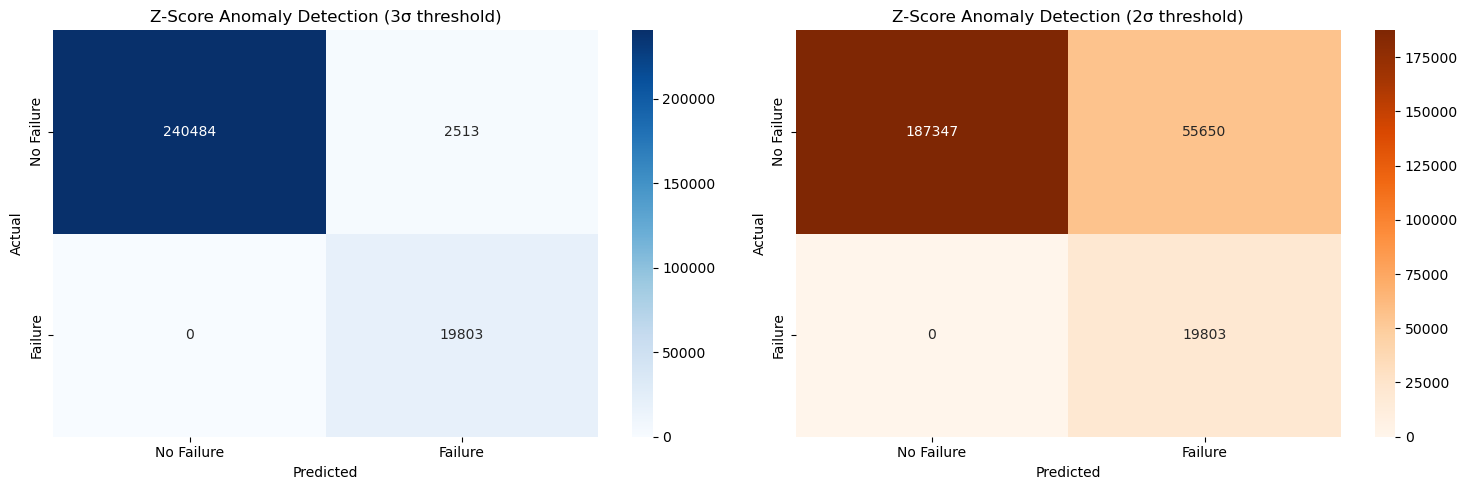

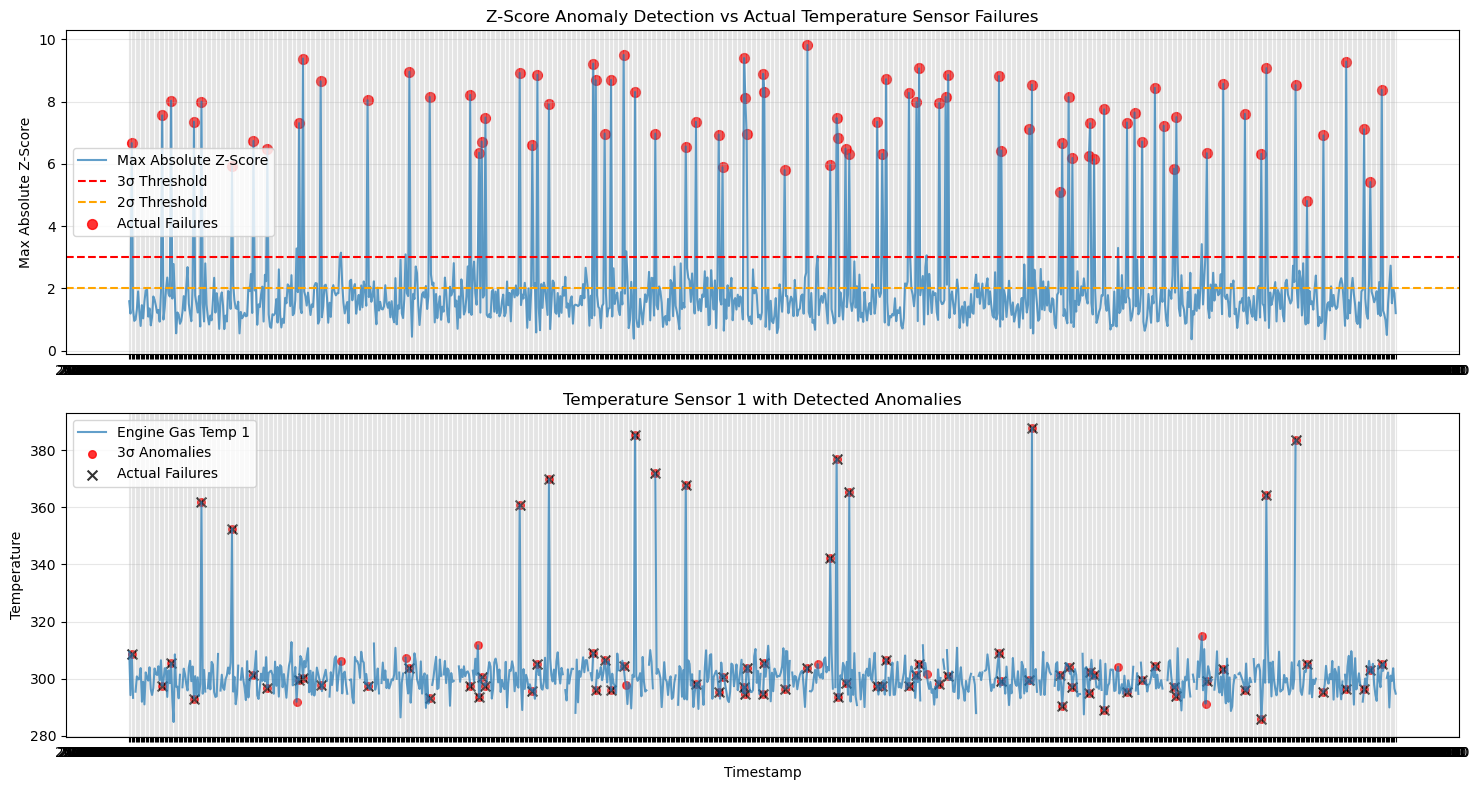

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve

# First, let's check if there are failure flags in the dataset
failure_cols = [col for col in df.columns if 'failure' in col.lower() or 'fault' in col.lower()]
print("Available failure columns:", failure_cols)

# If no failure columns exist, let's create synthetic failure flags based on extreme values
# We'll define failures as extreme outliers (beyond 4 sigma) in temperature sensors
temp_cols = [col for col in df.columns if 'enginegastemperature' in col]

# Create failure flags based on extreme temperature values
df_eval = df_with_zscore_features.copy()

# Define temperature sensor failures as values beyond 4 standard deviations
temp_failure_conditions = []
for col in temp_cols:
    if col in df.columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        extreme_condition = (abs(df[col] - mean_val) > 4 * std_val)
        temp_failure_conditions.append(extreme_condition)

# Combine all temperature sensor failure conditions
df_eval['temp_sensor_failure'] = pd.concat(temp_failure_conditions, axis=1).any(axis=1).astype(int)

# Use Z-score anomaly flags as predictions
y_true = df_eval['temp_sensor_failure']
y_pred_3sigma = df_eval['anomaly_flag_3sigma']
y_pred_2sigma = df_eval['anomaly_flag_2sigma']

# Remove NaN values for evaluation
valid_mask = ~(y_true.isna() | y_pred_3sigma.isna() | y_pred_2sigma.isna())
y_true_clean = y_true[valid_mask]
y_pred_3sigma_clean = y_pred_3sigma[valid_mask]
y_pred_2sigma_clean = y_pred_2sigma[valid_mask]

print(f"Dataset size after removing NaN: {len(y_true_clean)}")
print(f"Actual failures: {y_true_clean.sum()}")
print(f"Z-score anomalies (3σ): {y_pred_3sigma_clean.sum()}")
print(f"Z-score anomalies (2σ): {y_pred_2sigma_clean.sum()}")

# Create confusion matrices and evaluate models

# Evaluation for 3-sigma threshold
cm_3sigma = confusion_matrix(y_true_clean, y_pred_3sigma_clean)
print("\n=== Z-Score Model (3σ threshold) ===")
print("Confusion Matrix:")
print("                Predicted")
print("                No Failure  Failure")
print(f"Actual No Failure  {cm_3sigma[0,0]:8d}    {cm_3sigma[0,1]:6d}")
print(f"Actual Failure     {cm_3sigma[1,0]:8d}    {cm_3sigma[1,1]:6d}")

print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred_3sigma_clean, 
                          target_names=['No Failure', 'Failure']))

# Evaluation for 2-sigma threshold
cm_2sigma = confusion_matrix(y_true_clean, y_pred_2sigma_clean)
print("\n=== Z-Score Model (2σ threshold) ===")
print("Confusion Matrix:")
print("                Predicted")
print("                No Failure  Failure")
print(f"Actual No Failure  {cm_2sigma[0,0]:8d}    {cm_2sigma[0,1]:6d}")
print(f"Actual Failure     {cm_2sigma[1,0]:8d}    {cm_2sigma[1,1]:6d}")

print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred_2sigma_clean, 
                          target_names=['No Failure', 'Failure']))

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

# Compare metrics
metrics_3sigma = calculate_metrics(y_true_clean, y_pred_3sigma_clean)
metrics_2sigma = calculate_metrics(y_true_clean, y_pred_2sigma_clean)

print("\n=== Model Comparison ===")
print("Metric               3σ Threshold    2σ Threshold")
print("-" * 50)
for metric in metrics_3sigma.keys():
    print(f"{metric:<20} {metrics_3sigma[metric]:>12.4f}    {metrics_2sigma[metric]:>12.4f}")

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot confusion matrix for 3-sigma
sns.heatmap(cm_3sigma, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Z-Score Anomaly Detection (3σ threshold)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['No Failure', 'Failure'])
ax1.set_yticklabels(['No Failure', 'Failure'])

# Plot confusion matrix for 2-sigma
sns.heatmap(cm_2sigma, annot=True, fmt='d', cmap='Oranges', ax=ax2)
ax2.set_title('Z-Score Anomaly Detection (2σ threshold)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['No Failure', 'Failure'])
ax2.set_yticklabels(['No Failure', 'Failure'])

plt.tight_layout()
plt.show()

# Plot time series with anomalies and failures
plt.figure(figsize=(15, 8))

# Sample data for visualization (last 1000 points)
sample_size = 1000
sample_data = df_eval.tail(sample_size)

plt.subplot(2, 1, 1)
plt.plot(sample_data.index, sample_data['max_abs_zscore'], label='Max Absolute Z-Score', alpha=0.7)
plt.axhline(y=3, color='red', linestyle='--', label='3σ Threshold')
plt.axhline(y=2, color='orange', linestyle='--', label='2σ Threshold')
plt.scatter(sample_data[sample_data['temp_sensor_failure']==1].index, 
           sample_data[sample_data['temp_sensor_failure']==1]['max_abs_zscore'], 
           color='red', s=50, label='Actual Failures', alpha=0.8)
plt.title('Z-Score Anomaly Detection vs Actual Temperature Sensor Failures')
plt.ylabel('Max Absolute Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(sample_data.index, sample_data['enginegastemperature1'], label='Engine Gas Temp 1', alpha=0.7)
plt.scatter(sample_data[sample_data['anomaly_flag_3sigma']==1].index,
           sample_data[sample_data['anomaly_flag_3sigma']==1]['enginegastemperature1'],
           color='red', s=30, label='3σ Anomalies', alpha=0.8)
plt.scatter(sample_data[sample_data['temp_sensor_failure']==1].index,
           sample_data[sample_data['temp_sensor_failure']==1]['enginegastemperature1'],
           color='black', s=50, marker='x', label='Actual Failures', alpha=0.8)
plt.title('Temperature Sensor 1 with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()